In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from statistics import mean
from PIL import Image
from sklearn.cluster import KMeans

import numpy as np

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

class PersonDetector():
    def __init__(self, threshold):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        cfg.CLASS_INDICES = [0]
        cfg.CLASS_STRING = ['person']
        self.predictor = DefaultPredictor(cfg)
    
    def detectPersons(self, image):
        outputs = self.predictor(image)
        labels = outputs['instances'].pred_classes
        scores = outputs["instances"].scores
        masks = outputs['instances'].pred_masks
        boxes = outputs['instances'].pred_boxes
        return {"boxes": boxes, "labels":labels, "scores": scores, "masks":masks}

c:\Users\ferna\anaconda3\envs\efootball\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
person_detector = PersonDetector(threshold=0.6)

In [3]:
VIDEO_PATH = r'C:\Users\ferna\OneDrive\Documentos\Insper\Efootball\data\08fd33_0.mp4'
GRASS_BOUNDARIES = [np.array([40,70,40]), np.array([125,140,110])]

In [5]:
def remove_boundaries(image, boundaries):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    background = cv2.inRange(image, boundaries[0], boundaries[1])
    mask = 255 - background
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

In [6]:
GRASS_BOUNDARIES = [np.array([40,70,40]), np.array([125,140,110])]

[[104 146 122]
 [ 88 130 106]
 [ 62 102  83]
 ...
 [ 64 100  88]
 [ 61  99  80]
 [ 61  99  80]]


c:\Users\ferna\anaconda3\envs\efootball\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


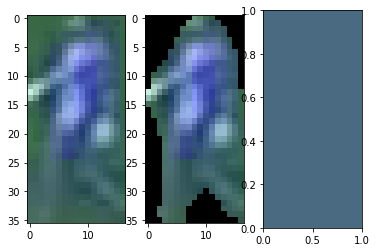

In [9]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
n_frames = 100
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

for i in range(1):
    ret, frame = cap.read()
    predictions = person_detector.detectPersons(frame)
    random_prediciton =  np.asarray(predictions["masks"].to("cpu"))
    item_mask = random_prediciton[1]
    segmentation = np.where(item_mask == True)
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))
    cropped = Image.fromarray(frame[y_min:y_max, x_min:x_max, :], mode='RGB')
    mask = (item_mask * 255).astype('uint8')
    result = cv2.bitwise_and(frame, frame, mask=mask)
    result_reshape = result.reshape((result.shape[0] * result.shape[1], 3))
    only_player = result_reshape[result_reshape.sum(axis=(1)) != 0]
    print(only_player)
    kmeans = KMeans(n_clusters = 1)
    kmeans.fit(only_player)
    rect = plt.Rectangle((0,0),10,10,color=kmeans.cluster_centers_[0]/255)
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(frame[y_min:y_max, x_min:x_max])
    ax[1].imshow(result[y_min:y_max, x_min:x_max])
    ax[2].add_patch(rect)
    plt.show()